In [44]:
from gensim import corpora, models
import gensim
import numpy as np
from scipy.sparse import csr_matrix
from random import shuffle
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%pylab inline
from wordcloud import WordCloud
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [14]:
def bow_to_corpus(bow_feature):
    corpus = []
    for i in xrange(bow_feature.shape[0]):
        line = bow_feature[i]
        tmp_corpus = []
        for (N,j) in enumerate(line):
            if j > 0:
                tmp_corpus.append((N,j))
        corpus.append(tmp_corpus)
    return corpus

In [20]:
def build_lda_feature(ldamodel,corpus):
    doc_lda = ldamodel[corpus]
    data = []
    row = []
    col = []
    for (N,doc) in enumerate(doc_lda):
        for i in doc:
            data.append(i[1])
            row.append(N)
            col.append(i[0])
    LDA_feature = csr_matrix((data,(row,col))).toarray()
    return LDA_feature

In [34]:
def logistic_regression_model(BoW_feature, LDA_feature,label):
    whole_feature = np.hstack((BoW_feature,LDA_feature))
    random_index = range(BoW_feature.shape[0])
    lda = []
    bow = []
    whole = []
    model = LogisticRegression(C = 0.1)
    shuffle(random_index)
    cross_num = int(len(random_index)/10.0)
    for i in xrange(10):
        if i == 0:
            train_label = random_index[(cross_num * (i+1)):]
        else:
            train_label = random_index[0:(cross_num * i)] + random_index[(cross_num * (i+1)):]
        test_label = random_index[(cross_num * i):(cross_num * (i+1))]
        model.fit(whole_feature[train_label],label[train_label])
        p = model.predict(whole_feature[test_label])
        whole.append(sum(label[test_label] == p)/float(len(p)))

        model.fit(BoW_feature[train_label],label[train_label])
        p = model.predict(BoW_feature[test_label])
        bow.append(sum(label[test_label] == p)/float(len(p)))

        model.fit(LDA_feature[train_label],label[train_label])
        p = model.predict(LDA_feature[test_label])
        lda.append(sum(label[test_label] == p)/float(len(p)))
    return whole, bow, lda

In [47]:
def corpus2text(dictionary,bow_feature):
    word_list = []
    for i in xrange(bow_feature.shape[0]):
        line = bow_feature[i]
        for (N,j) in enumerate(line):
            if j > 0:
                word_list.append(dictionary[N])
    return ' '.join(word_list)

In [8]:
bow_feature = np.load('bow_feature.npy')
label_feature = np.load('label.npy')
age_feature = np.load('age.npy')

In [9]:
bow_feature_0 = bow_feature[age_feature==0]
bow_feature_1 = bow_feature[age_feature==1]
label_feature_0 = label_feature[age_feature==0]
label_feature_1 = label_feature[age_feature==1]

In [15]:
corpus_0 = bow_to_corpus(bow_feature_0)

In [17]:
corpus_1 = bow_to_corpus(bow_feature_1)

In [18]:
dictionary = corpora.Dictionary.load('BoW.dict')

In [19]:
TOPIC = 20
ldamodel_0 = gensim.models.ldamodel.LdaModel(corpus_0, num_topics=TOPIC, id2word = dictionary, passes = 10,iterations = 100)
ldamodel_1 = gensim.models.ldamodel.LdaModel(corpus_1, num_topics=TOPIC, id2word = dictionary, passes = 10,iterations = 100)

In [23]:
LDA_feature_0 = build_lda_feature(ldamodel_0, corpus_0)
LDA_feature_1 = build_lda_feature(ldamodel_1, corpus_1)

In [35]:
whole_0, bow_0, lda_0 = logistic_regression_model(bow_feature_0, LDA_feature_0,label_feature_0)
whole_1, bow_1, lda_1 = logistic_regression_model(bow_feature_1, LDA_feature_1,label_feature_1)

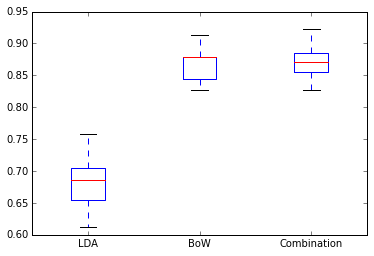

In [37]:
p = plt.boxplot((lda_0,bow_0,whole_0),labels=['LDA','BoW','Combination'])

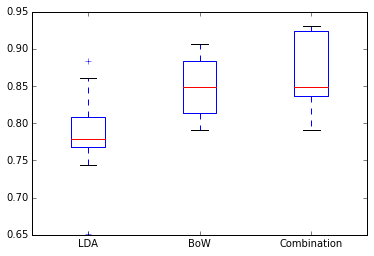

In [38]:
p = plt.boxplot((lda_1,bow_1,whole_1),labels=['LDA','BoW','Combination'])

In [48]:
depress_text = corpus2text(dictionary,bow_feature_0[label_feature_0 == 1])

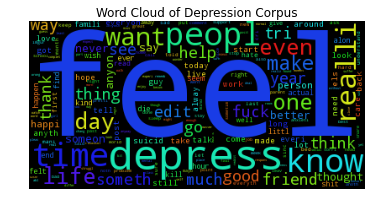

In [49]:
wordcloud = WordCloud().generate(depress_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud of Depression Corpus')
plt.show()

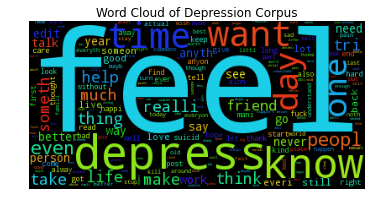

In [50]:
depress_text = corpus2text(dictionary,bow_feature_1[label_feature_1 == 1])
wordcloud = WordCloud().generate(depress_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud of Depression Corpus')
plt.show()

In [56]:
age_feature.shape

(1598,)